# AllRecipes.com scraper

This python notebook is used to scrape recipes and users of the allrecipes.com platform in order to create a user/item matrix that will be used to design a recipes recommender system based on ingredients, recipe style, user preferences, reviews, ratings, etc...


In [1]:
from urllib.request import *
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as pl
import matplotlib.pyplot as plt
import requests
import json
import os
from util import *
%matplotlib inline

endpoint = 'http://allrecipes.com/recipes/?grouping=all&page='

In [2]:
def parsePage(page):
    articlesList = []
    articles = page.find_all("article")
    for article in articles:
        if article.h3 is not None:
            name = removeSpace(article.h3.text)
            if name != "":
                print(name)
                try:
                    ratingStars = article.find("div",{"class" : "rating-stars"})["data-ratingstars"]
                    nbReviews = article.find("format-large-number")["number"]
                except:
                    ratingStars = None
                    nbReviews = None
                link = article.find('a', href=re.compile('^/recipe/'))
                if link is not None:
                    print(link['href'])
                    articlesList.append([name, ratingStars, nbReviews, link['href']])
                else:
                    link = article.find('a', href=re.compile('^/cook/'))
                    if link is not None:
                        print(link['href'])
                        articlesList.append([name, ratingStars, nbReviews, link['href']])
                    else:
                        print("REALLY NO LINKS")
    return articlesList

In [3]:
'''articlesList = []
for i in range(1, 2):
    response = urlopen(endpoint + str(i))
    html = response.read()
    page = BeautifulSoup(html, 'html.parser')
    articlesList += parsePage(page)
    print("Scraping page " + str(i))
    '''

'articlesList = []\nfor i in range(1, 2):\n    response = urlopen(endpoint + str(i))\n    html = response.read()\n    page = BeautifulSoup(html, \'html.parser\')\n    articlesList += parsePage(page)\n    print("Scraping page " + str(i))\n    '

In [4]:
'''articles = pd.DataFrame(articlesList)
articles.columns=["Recipe title", "Rating", "Reviews", "Recipe link"]
articles'''

'articles = pd.DataFrame(articlesList)\narticles.columns=["Recipe title", "Rating", "Reviews", "Recipe link"]\narticles'

In [5]:
'''articles.to_csv("indexes/RecipeLinks.csv", index=False, encoding='utf-8')'''

'articles.to_csv("indexes/RecipeLinks.csv", index=False, encoding=\'utf-8\')'

## Merging all links

In [6]:
'''articles_1000 = pd.read_csv("indexes/1000_RecipeLinks.csv")
articles_2000 = pd.read_csv("indexes/2000_RecipeLinks.csv")
articles_3000 = pd.read_csv("indexes/3000_RecipeLinks.csv")
all_articles = pd.concat([articles_1000, articles_2000, articles_3000])
all_articles.to_csv("indexes/RecipeLinks.csv", index=False, encoding='utf-8')
'''

'articles_1000 = pd.read_csv("indexes/1000_RecipeLinks.csv")\narticles_2000 = pd.read_csv("indexes/2000_RecipeLinks.csv")\narticles_3000 = pd.read_csv("indexes/3000_RecipeLinks.csv")\nall_articles = pd.concat([articles_1000, articles_2000, articles_3000])\nall_articles.to_csv("indexes/RecipeLinks.csv", index=False, encoding=\'utf-8\')\n'

## Analyzing links and number of reviews

In [7]:
all_articles = pd.read_csv("indexes/RecipeLinks.csv")
cleaned_articles = all_articles.dropna().reset_index()
del cleaned_articles['index']
reviews = cleaned_articles["Reviews"]

In [8]:
cleaned_articles.describe()

,Unnamed: 0,Rating,Reviews
count,59800.000000,59800.000000,59800.000000
mean,29912.495652,3.901782,65.999532
std,17262.924914,1.323218,294.742222
min,0.000000,0.000000,0.000000
25%,14962.750000,3.970000,3.000000
50%,29912.500000,4.330000,12.000000
75%,44862.250000,4.600000,42.000000
max,59812.000000,5.000000,10833.000000


In [9]:
print("Recipes with more than 50 reviews: " + str(len(cleaned_articles[cleaned_articles["Reviews"] > 50])))
print("Recipes with more than 100 reviews: " + str(len(cleaned_articles[cleaned_articles["Reviews"] > 100])))
print("Recipes with more than 1000 reviews: " + str(len(cleaned_articles[cleaned_articles["Reviews"] > 1000])))

Recipes with more than 50 reviews: 13089
Recipes with more than 100 reviews: 7341
Recipes with more than 1000 reviews: 507


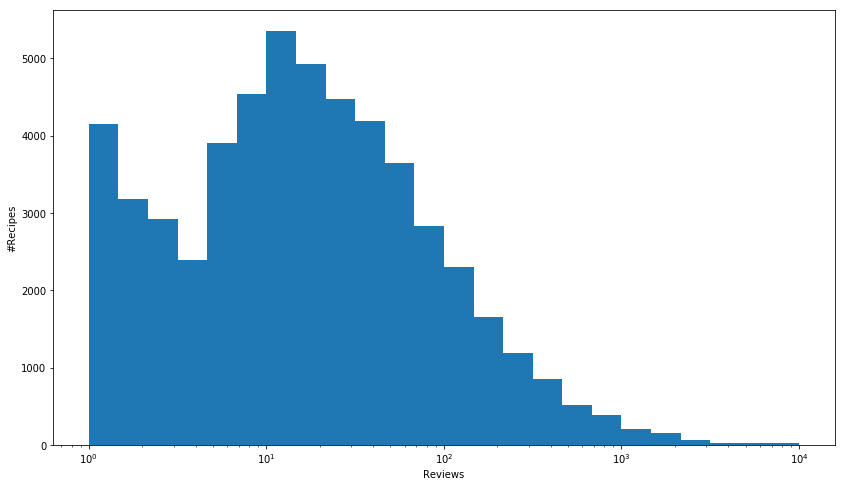

In [10]:
fig = plt.gcf()
fig.set_size_inches(14, 8)
plt.hist(reviews, bins=np.logspace(0, 4, 25))
plt.gca().set_xscale("log")
#plt.gca().set_yscale("log")
plt.xlabel('Reviews')
plt.ylabel('#Recipes')
plt.show()

# Scraping recipe

In [11]:
recipe_endpoint = "http://allrecipes.com"

In [12]:
def parseRecipe(recipe):
    articlesList = []
    articles = page.find_all("article")
    for article in articles:
        if article.h3 is not None:
            name = ''.join(article.h3.text.split("\n"))
            split = name.split(" ")
            name = ""
            for part in split:
                if part != "":
                    name += part + " "
            name = name[:-1]
            if name != "":
                print(name)
                try:
                    ratingStars = article.find("div",{"class" : "rating-stars"})["data-ratingstars"]
                    nbReviews = article.find("format-large-number")["number"]
                except:
                    ratingStars = None
                    nbReviews = None
                link = article.find('a', href=re.compile('^/recipe/'))
                if link is not None:
                    print(link['href'])
                    articlesList.append([name, ratingStars, nbReviews, link['href']])
                else:
                    link = article.find('a', href=re.compile('^/cook/'))
                    if link is not None:
                        print(link['href'])
                        articlesList.append([name, ratingStars, nbReviews, link['href']])
                    else:
                        print("REALLY NO LINKS")
    return articlesList

### Get all reviews of a recipe

In [13]:
reviews_endpoint = "http://allrecipes.com/recipe/getreviews/"

In [14]:
def getAllShortReviews(recipe_id, nbReviews):
    params = {
        "recipeid": recipe_id,
        "pagenumber": 1,
        "pagesize": nbReviews,
        "recipeType": "Recipe",
        "sortBy": "MostHelpful"
    }
    r = requests.get(reviews_endpoint, params=params)
    response = BeautifulSoup(r.text, 'html.parser')
    html_reviews = response.find_all("div", {"class": "review-container clearfix"})
    reviews = []
    for rev in html_reviews:
        author_ref = rev.find("a")["href"]
        author_name = removeSpace(rev.find("h4",{"itemprop":"author"}).text)
        author_infos = rev.find_all("format-large-number")
        author_followers = author_infos[0]["number"]
        author_favorites = author_infos[1]["number"]
        author_recipes = author_infos[2]["number"]
        print(rev)
        review = {"author_ref": author_ref, "author_name": author_name, "author_followers": author_followers, 
                        "author_favorites": author_favorites, "author_recipes": author_recipes}
        reviews.append(review)
        
    return reviews

In [15]:
def getRecipeReviews(endpoint, page, size, token):
    params = {
        "page": page,
        "pagesize": size,
    }

    session = requests.Session()
    r = requests.get(endpoint, params=params, headers={'Authorization': 'Bearer ' + token})
    response = json.loads(r.text)
    if "reviews" in response:
        print("Retrieved reviews: " + str(len(response["reviews"])))
        return response["reviews"]
    else:
        print("No reviews")
        return None

In [16]:
max_review = 100

def getAllRecipeReviews(endpoint, size, token):
    all_reviews = []
    nb_reviews = 0
    page = 1
    while (size - nb_reviews) > max_review:
        reviews = getRecipeReviews(endpoint, page, max_review, token)
        nb_reviews += max_review
        page += 1
        if reviews is not None:
            all_reviews = all_reviews + reviews
        
    reviews = getRecipeReviews(endpoint, page, (size - nb_reviews), token)
    nb_reviews += (size - nb_reviews)
    if reviews is not None:
        all_reviews = all_reviews + reviews
    
    return all_reviews

### Getting photos metadatas

In [17]:
def getRecipePhotos(endpoint, page, size, token):
    params = {
        "page": page,
        "pagesize": size,
    }

    session = requests.Session()
    r = requests.get(endpoint, params=params, headers={'Authorization': 'Bearer ' + token})
    response = json.loads(r.text)
    if "photos" in response:
        print("Retrieved photos: " + str(len(response["photos"])))
        return response["photos"]
    else:
        print("No photos")
        return None

In [18]:
max_photo = 100

def getAllRecipePhotos(endpoint, size, token):
    all_photos = []
    nb_photos = 0
    page = 1
    while (size - nb_photos) > max_photo:
        photos = getRecipePhotos(endpoint, page, max_photo, token)
        nb_photos += max_photo
        page += 1
        if photos is not None:
            all_photos = all_photos + photos
        
    photos = getRecipePhotos(endpoint, page, (size - nb_photos), token)
    nb_photos += (size - nb_photos)
    if photos is not None:
        all_photos = all_photos + photos
    
    return all_photos

### What to scrape for a Recipe

Interesting properties:
* Author
* Description
* \# Made it
* \# Reviews
* \# Photos
* Photos metadatas
* Ingredients
* Prep time
* Cooking time
* Nutrition facts
* Number of ratings
    * Loved it
    * Liked it
    * OK
    * Didn't like it
    * Couldn't eat it
* Instructions

In [19]:
def getRecipeInfos(recipe_page, recipe_data):
    infos = recipe_page.find("div",{"class":"total-made-it"})
    recipe_data["made_it_count"] = infos["data-ng-init"].split("(")[1].split(",")[0]
    recipe_data["reviews_count"] = infos.find("span",{"class":"review-count"}).text.split(" ")[0]
    recipe_data["photos_count"] = infos.find("format-large-number")["number"]

    recipe_data["description"] = recipe_page.find("div", {"class":"submitter__description"}).text
    recipe_data["featured_in_magazine"] = (len(recipe_page.find_all("span",{"class":"recipe-summary__magazine__font"})) > 0)

    html_ingredients = recipe_page.find_all("span", {"class":"recipe-ingred_txt added","itemprop":"ingredients"})
    ingredients = []
    for ing in html_ingredients:
        ingredients.append({"id":ing["data-id"],"text":ing.text})
    recipe_data["ingredients"] = ingredients
    
    try:
        recipe_data["ready_time"] = recipe_page.find("span",{"class":"ready-in-time"}).text
    except:
        recipe_data["ready_time"] = None
    try:
        recipe_data["prep_time"] = recipe_page.find("time", {"itemprop":"prepTime"}).text
    except:
        recipe_data["prep_time"] = None
    try:
        recipe_data["cook_time"] = recipe_page.find("time", {"itemprop":"cookTime"}).text
    except:
        recipe_data["cook_time"] = None
        
    try:
        html_nutri_facts = recipe_page.find("section", {"class":"ng-hide recipe-nutrition panel"})
        nutri_facts = {}
        nutri_facts["calories"] = html_nutri_facts.find("li",{"class":"nutrientLine__item--amount", "itemprop":"calories"}).text
        nutri_facts["fatContent"] = html_nutri_facts.find("li",{"class":"nutrientLine__item--amount", "itemprop":"fatContent"}).text
        nutri_facts["carbohydrateContent"] = html_nutri_facts.find("li",{"class":"nutrientLine__item--amount", "itemprop":"carbohydrateContent"}).text
        nutri_facts["proteinContent"] = html_nutri_facts.find("li",{"class":"nutrientLine__item--amount", "itemprop":"proteinContent"}).text
        nutri_facts["cholesterolContent"] = html_nutri_facts.find("li",{"class":"nutrientLine__item--amount", "itemprop":"cholesterolContent"}).text
        nutri_facts["sodiumContent"] = html_nutri_facts.find("li",{"class":"nutrientLine__item--amount", "itemprop":"sodiumContent"}).text
        recipe_data["nutri_facts"] = nutri_facts
    except:
        recipe_data["nutri_facts"] = None
        
    instructions = list(map(lambda x: removeSpace(x.text), recipe_page.find_all("li",{"class":"step"})))
    instructions = list(filter(lambda x: (x != "" and x != None), instructions))
    recipe_data["instructions"] = instructions
                
    stars_rate = list(map(lambda x: x["style"].split(" ")[1].split("%")[0], recipe_page.find_all("div",{"class":"reviewsummary--percent"})))
    recipe_data["stars_rate"] = stars_rate

### Scrape a recipe

In [20]:
def scrapeRecipe(recipe_link):

    recipe_id = recipe_link.split("/")[2]
    
    directory = 'recipe_data/' + recipe_id + "/"
    fname = directory + "photos.json"
    if os.path.isfile(fname) :
        return False
    
    session = requests.Session()
    r = requests.get("http://allrecipes.com" + recipe_link)
    recipe_page = BeautifulSoup(r.text, 'html.parser')
    token = r.cookies.get_dict()["ARToken"]

    print("Scraping Recipe with link: " + recipe_link)

    recipe_data = {}
    getRecipeInfos(recipe_page, recipe_data)
    
    if os.path.exists(directory):
        i = 3
    else:
        os.makedirs(directory)
    
    with open('recipe_data/' + recipe_id + "/data.json", 'w+') as outfile:
        json.dump(recipe_data, outfile)
    
         
    reviews_endpoint = "https://apps.allrecipes.com/v1/recipes/"+str(recipe_id) + "/reviews/"
    reviews = getAllRecipeReviews(reviews_endpoint, int(recipe_data["reviews_count"]), token)
    with open('recipe_data/' + recipe_id + "/reviews.json", 'w+') as outfile:
        json.dump(reviews, outfile)
      
    photos_endpoint = "https://apps.allrecipes.com/v1/recipes/" + str(recipe_id) + "/photos"
    photos = getAllRecipePhotos(photos_endpoint, int(recipe_data["photos_count"]), token)
    with open('recipe_data/' + recipe_id + "/photos.json", 'w+') as outfile:
        json.dump(photos, outfile)
        
    print(recipe_id + " scraped")
    return recipe_page

In [31]:
def getNutritionalFacts(recipe_id, token):
    directory = 'recipe_data/' + recipe_id + "/"
    fname = directory + "nutrition.json"
    if os.path.isfile(fname) :
        return False
    
    endpoint = "https://apps.allrecipes.com/v1/recipes/" + recipe_id
    params = {
        "fields": "nutrition",
        "isMetric": "false",
    }
    r = requests.get(endpoint, params=params, headers={'Authorization': 'Bearer ' + token})

    
    try:
        nutrition = json.loads(r.text)
        with open('recipe_data/' + recipe_id + "/nutrition.json", 'w+') as outfile:
            json.dump(nutrition, outfile)
    except:
        print("error")
        print(r.text)
        

In [ ]:
recipe_ids = cleaned_articles["Recipe link"].map(lambda x: x.split("/")[2])

session = requests.Session()
r = requests.get("http://allrecipes.com" + "/recipe/12342/oatmeal-pie-ii/")
recipe_page = BeautifulSoup(r.text, 'html.parser')
token = r.cookies.get_dict()["ARToken"]

i = 0
for recipe_id in recipe_ids:
    getNutritionalFacts(recipe_id, token)
    i+=1
    if(i % 100) == 0:
        print("Got " + str(i) + "/" + str(len(recipe_ids)))


Got 100/59800
Got 200/59800
Got 300/59800
Got 400/59800
Got 500/59800
Got 600/59800
Got 700/59800
Got 800/59800
Got 900/59800
Got 1000/59800
Got 1100/59800
Got 1200/59800
Got 1300/59800
Got 1400/59800
Got 1500/59800
Got 1600/59800
Got 1700/59800
Got 1800/59800
Got 1900/59800
Got 2000/59800
Got 2100/59800
Got 2200/59800
Got 2300/59800
Got 2400/59800
Got 2500/59800
error

Got 2600/59800
Got 2700/59800
Got 2800/59800


## Scraping all recipes

In [21]:
scraped_articles = cleaned_articles
scraped_articles = scraped_articles.reset_index()
del scraped_articles["index"]
len(scraped_articles)

59800

In [22]:
import threading
import time

In [23]:
index = 0
for recipe in scraped_articles["Recipe link"]:
    scrapeRecipe(recipe)
    index += 1
    #print("got " + str(index))

In [24]:
'''nb_threads = 1
index = 0

nb_made = 49

while index < len(scraped_articles):
    if (len(scraped_articles) - index) < nb_threads:
        nb_threads = (len(scraped_articles) - index)

    threads = []
    
    for i in range(nb_threads):
        print("index: " + str(i+index))
        t = threading.Thread(target=scrape,args=(scraped_articles["Recipe link"][i+index],))
        t.daemon = True
        t.start()
        threads.append(t)

    for t in threads:
        t.join()
    
    nb_made += 1
    index += nb_threads
    
    if nb_made % 50 == 0:
        time.sleep(5)'''

'nb_threads = 1\nindex = 0\n\nnb_made = 49\n\nwhile index < len(scraped_articles):\n    if (len(scraped_articles) - index) < nb_threads:\n        nb_threads = (len(scraped_articles) - index)\n\n    threads = []\n    \n    for i in range(nb_threads):\n        print("index: " + str(i+index))\n        t = threading.Thread(target=scrape,args=(scraped_articles["Recipe link"][i+index],))\n        t.daemon = True\n        t.start()\n        threads.append(t)\n\n    for t in threads:\n        t.join()\n    \n    nb_made += 1\n    index += nb_threads\n    \n    if nb_made % 50 == 0:\n        time.sleep(5)'

# Scraping Users

In [23]:
url_start = "https://apps.allrecipes.com/v1/users/"
url_end = "/made"

In [24]:
def getUserMadeIt(page, size, user_id, token):
    params = {
        "page": 1,
        "pagesize": 1000
    }
    r = requests.get(url_start + user_id + url_end, params=params, headers={'Authorization': 'Bearer ' + token})
    response = json.loads(r.text)
    
    if "recipes" in response:
        #print("Retrieved user made recipes: " + str(len(response["recipes"])))
        return response["recipes"]
    else:
        print("No recipes")
        return None

In [25]:
max_made_it = 100

def getAllUserMadeIt(user_id, size, token):
    all_made_it = []
    nb_made_it = 0
    page = 1
    while (size - nb_made_it) > max_made_it:
        made_it = getUserMadeIt(page, max_made_it, user_id, token)
        nb_made_it += max_made_it
        page += 1
        if made_it is not None:
            all_made_it = all_made_it + made_it
        
    made_it = getUserMadeIt(page, (size - nb_made_it), user_id, token)
    nb_made_it += (size - nb_made_it)
    if made_it is not None:
        all_made_it = all_made_it + made_it
    
    return all_made_it

In [26]:
def getUserInfos(user_page, user_data):
    infos = ["FollowersCount","FollowingCount","FavoriteCount","MadeRecipesCount","RatingCount","PersonalRecipeSharedCount","SubmittedRecipesCount"]
    
    for info in infos:
        parts = str(user_page).split(info + "\":")
        count = 0
        for s in parts[1:]:
            count = max(int((s.split(",")[0])), count)
        user_data[info] = count    

In [27]:
def scrapeUser(user_id):
    
    directory = 'user_data/' + user_id + "/"
    fname = directory + "recipes.json"
    if os.path.isfile(fname) :
        return False
    
    session = requests.Session()
    r = requests.get("http://allrecipes.com/cook/" + user_id)
    user_page = BeautifulSoup(r.text, 'html.parser')
    token = r.cookies.get_dict()["ARToken"]

    #print("Scraping User : " + user_id)

    user_data = {}
    
    getUserInfos(user_page, user_data)
    
    
    if os.path.exists(directory):
        i = 3
    else:
        os.makedirs(directory)
    
    with open('user_data/' + user_id + "/data.json", 'w+') as outfile:
        json.dump(user_data, outfile)
         
    made_it = getAllUserMadeIt(user_id, int(user_data["MadeRecipesCount"]), token)
    with open('user_data/' + user_id + "/recipes.json", 'w+') as outfile:
        json.dump(made_it, outfile)
        
    #print(user_id + " scraped")

In [28]:
scrapeUser("2526564")

False

## Getting list of users

In [29]:
recipes = [f.path.split("/")[1] for f in os.scandir("recipe_data/") if f.is_dir() ]    
print(recipes[:10])
print("Nb of recipes: " + str(len(recipes)))

['229804', '245348', '25093', '14930', '257743', '255991', '236394', '13148', '18454', '215435']
Nb of recipes: 44069


In [30]:
def getAllUsersWithReviews(start_path, files):
    users = set()
    for file in files:
        try:
            with open(start_path + file + "/reviews.json") as data_file:    
                reviews = json.load(data_file)
                for review in reviews:
                    users.add(review["submitter"]["userID"])
        except: 
            print("Problem with file: " + file)
    return users

In [31]:
'''
users = getAllUsersWithReviews("recipe_data/", recipes)
dfUsers = pd.DataFrame(list(users))
dfUsers.to_csv("users.csv")
'''

'\nusers = getAllUsersWithReviews("recipe_data/", recipes)\ndfUsers = pd.DataFrame(list(users))\ndfUsers.to_csv("users.csv")\n'

In [32]:
users = pd.read_csv("users.csv")["user_id"]

In [ ]:
i = 0
for user in users:
    i += 1
    try:
        scrapeUser(str(user))
    except:
        print("error")
    if i % 2 == 0:
        print("Scraped " + str(i) + " recipes")

Scraped 2 recipes
Scraped 4 recipes
Scraped 6 recipes
Scraped 8 recipes
Scraped 10 recipes
Scraped 12 recipes
Scraped 14 recipes
Scraped 16 recipes
Scraped 18 recipes
Scraped 20 recipes
Scraped 22 recipes
Scraped 24 recipes
Scraped 26 recipes
Scraped 28 recipes
Scraped 30 recipes
Scraped 32 recipes
Scraped 34 recipes
Scraped 36 recipes
Scraped 38 recipes
Scraped 40 recipes
Scraped 42 recipes
Scraped 44 recipes
Scraped 46 recipes
Scraped 48 recipes
Scraped 50 recipes
Scraped 52 recipes
Scraped 54 recipes
Scraped 56 recipes
Scraped 58 recipes
Scraped 60 recipes
Scraped 62 recipes
Scraped 64 recipes
Scraped 66 recipes
Scraped 68 recipes
Scraped 70 recipes
Scraped 72 recipes
Scraped 74 recipes
Scraped 76 recipes
Scraped 78 recipes
Scraped 80 recipes
Scraped 82 recipes
Scraped 84 recipes
Scraped 86 recipes
Scraped 88 recipes
Scraped 90 recipes
Scraped 92 recipes
Scraped 94 recipes
Scraped 96 recipes
Scraped 98 recipes
Scraped 100 recipes
Scraped 102 recipes
Scraped 104 recipes
Scraped 106 r

In [35]:
with open('users.txt', mode='wt', encoding='utf-8') as myfile:
    for user in users[:10]:
        print("http://allrecipes.com/cook/" + str(user), file = myfile)
myfile.close

<function TextIOWrapper.close>